In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

import desc
from desc.objectives import *
from desc.basis import ZernikePolynomial, FourierZernikeBasis, DoubleFourierSeries
from desc.transform import Transform
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.plotting import *
from desc.optimize import Optimizer
from desc.perturbations import *
import numpy as np
# np.set_printoptions(linewidth=np.inf)

from desc.geometry import (
    FourierRZToroidalSurface,  
    SplineXYZCurve, 
    FourierXYZCurve,
)
%matplotlib inline
from desc.utils import copy_coeffs
import matplotlib.pyplot as plt
from desc.examples import get
from desc.objectives.getters import (
    get_fixed_boundary_constraints, 
    maybe_add_self_consistency,
)
from desc.grid import LinearGrid, QuadratureGrid, Grid
import plotly.graph_objects as go
from desc.profiles import PowerSeriesProfile
from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.compute import data_index
from desc.coils import SplineXYZCoil
from desc.equilibrium import Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.objectives import (
    ObjectiveFunction,
    ForceBalance,
    get_fixed_boundary_constraints,
)
from desc.optimize import Optimizer
from desc.plotting import *
from desc.profiles import PowerSeriesProfile
from desc.examples import get
from desc.grid import LinearGrid
import plotly.graph_objects as go

from scipy.linalg import qr_insert, qr

import jax.numpy as jnp
from jax.lax import fori_loop
from jax.lax import rsqrt
import jax

import functools
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import factorize_linear_constraints
from desc.utils import svd_inv_null

from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic

DESC version 0.12.1+840.g66c11d2f7,using JAX backend, jax version=0.4.28, jaxlib version=0.4.28, dtype=float64
Using device: CPU, with 11.45 GB available memory


(<Figure size 384.189x384.189 with 1 Axes>,
 <Axes: xlabel='$\\rho$', ylabel='$ \\iota ~(~)$'>)

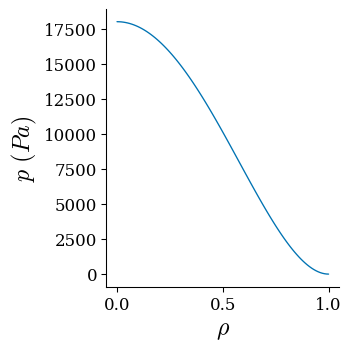

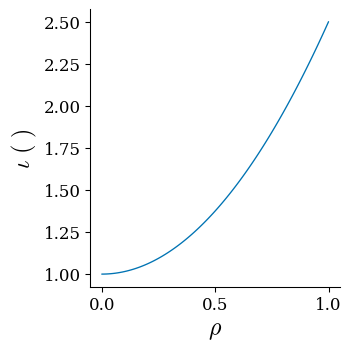

In [3]:
font = {'size'   : 18}

plt.rc('font', **font)
eq = get("HELIOTRON")
plot_1d(eq, 'p')
plot_1d(eq, 'iota')

In [2]:
eqs = ["HELIOTRON", "ATF", "W7-X", "ARIES-CS", "ESTELL", "HSX", "precise_QA",  "DSHAPE"]
print(f"{'Name':10} {'L':>3} {'M':>3} {'N':>3} {'LCFS Coeffs':>12} {'Poincare Coeffs':>15}")
print("="*51)
for eq_name in eqs:
    eq = get(eq_name)
    eqp = eq.set_poincare_equilibrium()
    numF = len(eq.Rb_lmn) + len(eq.Zb_lmn)
    numP = len(eqp.Rp_lmn) + len(eqp.Zp_lmn) #+ len(eqp.Lp_lmn)
    print(f"{eq_name:10} {eq.L:>3} {eq.M:>3} {eq.N:>3} {numF:>12} {numP:>15}")

Name         L   M   N  LCFS Coeffs Poincare Coeffs
HELIOTRON   24  12   3          175             241
ATF         24  12   4          225             241
W7-X        24  12  12          625             241
ARIES-CS    24  12   8          425             241
ESTELL      12  12   6          325              91
HSX         12  12   8          425              91
precise_QA   8   8   8          289              45
DSHAPE      26  13   0           27             280


In [25]:
eq = get("ARIES-CS")
eq.change_resolution(L=30, L_grid=52)
eqp = eq.set_poincare_equilibrium()
eqp.change_resolution(L=30, L_grid=52)
numF = len(eq.Rb_lmn) + len(eq.Zb_lmn)
numP = len(eqp.Rp_lmn) + len(eqp.Zp_lmn) + len(eqp.Lp_lmn)
print(f"{eq.L:>3} {eq.M:>3} {eq.N:>3} {numF:>12} {numP:>15}")

 30  12   8          425             442


In [3]:
fig = go.Figure()
for r in [0.3, 0.6, 1]:
    grid = LinearGrid(
        rho=r,
        theta=np.linspace(0, 2 * np.pi, 200),
        zeta=np.linspace(0, 2 * np.pi, 200),
        sym=True,
    )
    grid_points = LinearGrid(
            rho=r,
            theta=np.linspace(0, 2 * np.pi, 20),
            zeta=np.linspace(0, 2 * np.pi/eq.NFP, 10),
            NFP=eq.NFP,
            sym=True,
        )
    data = eq.compute(["X", "Y", "Z"], grid=grid_points)
    x = data["X"]
    y = data["Y"]
    z = data["Z"]
    plot_3d(eq, "|B|", grid=grid, fig=fig)
#     fig.add_trace(go.Scatter3d(x=x, 
#                         y=y, 
#                         z=z,
#                         mode='markers', 
#                         marker=dict(   
#                             color='black', 
#                             size=12,    
#                             opacity=1
#                             )
#                         )
#                     )
fig.show()